# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
g = np.array([2 / 10, 8 / 10])
round(-np.sum(g * np.log(g)), 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
gl = np.array([1])
gr = np.array([1])

round(np.sum(g * (1 - g)) - 0.8 * np.sum(gl * (1 - gl)) - 0.2 * np.sum(gr * (1 - gr)), 2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
leaf = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
leaf.mean()

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # функция для реализации разделения без цикла
    def split(t):
      if feature_type == 'real':
          mask = df['feature'] >= t
          right = df[mask]
          left = df[~mask]
      else:
          mask = df['feature'] != t
          right = df[mask]
          left = df[~mask]

      if len(left['target']) != 0 and len(right['target']) != 0:
        length_l = len(left['target'])
        length_r = len(right['target'])

        if task == 'classification':
          l_counts = np.bincount(left['target']) / length_l
          r_counts = np.bincount(right['target']) / length_r

          HRl = np.sum(l_counts * (1 - l_counts))
          HRr = np.sum(r_counts * (1 - r_counts))

          g = HRm - length_l / main_length * HRl - length_r / main_length * HRr
        else:
          g = np.var(df['target']) - length_l / main_length * np.var(left['target']) - length_r / main_length * np.var(right['target'])

        thresholds.append(t)
        ginis.append(g)



    s_feature_vector = sorted(np.unique(feature_vector))

    # для удобства соединяем в одну таблицу
    df = np.dstack([np.array(feature_vector), np.array(target_vector)])[0]
    df = pd.DataFrame(df, columns = ['feature','target'])

    if feature_type == 'real':
      thresholds_young = list(map(lambda x, y: (x + y) / 2, s_feature_vector[0::2], s_feature_vector[1::2]))
      thresholds_young = thresholds_young + list(map(lambda x, y: (x + y) / 2, s_feature_vector[0::2][1:], s_feature_vector[1::2]))
      thresholds_young = np.array(sorted(np.unique(thresholds_young)))
    else:
      thresholds_young = np.unique(s_feature_vector)

    main_length = len(df['target'])
    ginis = []
    threshold_best = thresholds_young[0]
    thresholds = []
    gini_best = -1

    # пригождается для классификации:
    counts = np.bincount(df['target']) / main_length
    HRm = np.sum(counts * (1 - counts))


    vectorizer = np.vectorize(split)
    vectorizer(thresholds_young)

    if len(ginis) == 0:
      gini_best = 0
      threshold_best = np.unique(thresholds_young)
    else:
      index = ginis.index(max(ginis))
      gini_best = ginis[index]
      threshold_best = thresholds[index]

    return (np.array(thresholds), np.array(ginis), threshold_best, gini_best)

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
X = pd.DataFrame(data=california.data, columns=california.feature_names)
y = california.target
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [ ]:
best = find_best_split(X['MedInc'], y, 'regression')
best

(array([ 0.51795,  0.51795,  0.54275, ..., 14.7421 , 14.95045, 15.00005]),
 array([0.0001088 , 0.0001088 , 0.0001856 , ..., 0.0199786 , 0.01956096,
        0.01872587]),
 5.03515,
 0.4127513862016769)

Text(0, 0.5, 'Error')

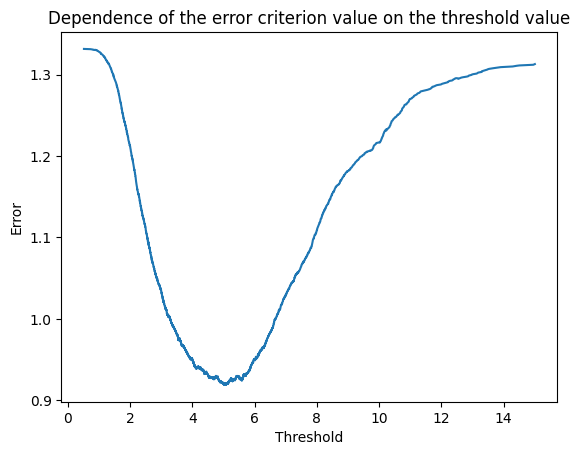

In [ ]:
plt.plot(best[0], -best[1] + np.var(y))
plt.title('Dependence of the error criterion value on the threshold value')
plt.xlabel('Threshold')
plt.ylabel('Error')

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [ ]:
#протестируем все признаки
for j in X.columns:
  best_j = find_best_split(X[j], y, 'regression')
  print(f'{j}: {best_j[2]}, {best_j[3]}')

MedInc: 5.03515, 0.4127513862016769
HouseAge: 51.5, 0.030900940598320964
AveRooms: 6.374305146225346, 0.1592079525892251
AveBedrms: 1.1033776245480702, 0.015253415595943787
Population: 1160.5, 0.0028306480479911578
AveOccup: 3.1125433206272035, 0.07391870577793286
Latitude: 37.935, 0.09033408765371977
Longitude: -121.86500000000001, 0.05021105203303022


Максимальный критерий информативности достигается в признаке MedInc, с предикатом df['MedInc'] < 5.03515

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:

class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"

    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self.feature_importances = None

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова (все объекты относятся к одному классу)
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]    # название real или categorical
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError


        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        self.feature_importances[feature_best] += gini_best # в лучший признак добавляем Gini
        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == 'terminal':
          return node["class"]

        feature = node["feature_split"]
        if self._feature_types[feature] == 'real':
          threshold = node["threshold"]
          if x[feature] < threshold:
            return self._predict_node(x, node['left_child'])
          else:
            return self._predict_node(x, node['right_child'])
        else:
          category = node["category_split"]
          if x[feature] == category:
            return self._predict_node(x, node['left_child'])
          else:
            return self._predict_node(x, node['right_child'])


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.feature_importances = [0 for i in range(X.shape[1])] # для feature_importances
        self._fit_node(X, y, self._tree)


    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tr = DecisionTreeRegressor()
tr.fit(X_train, y_train)

tr.predict(X_test)


**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

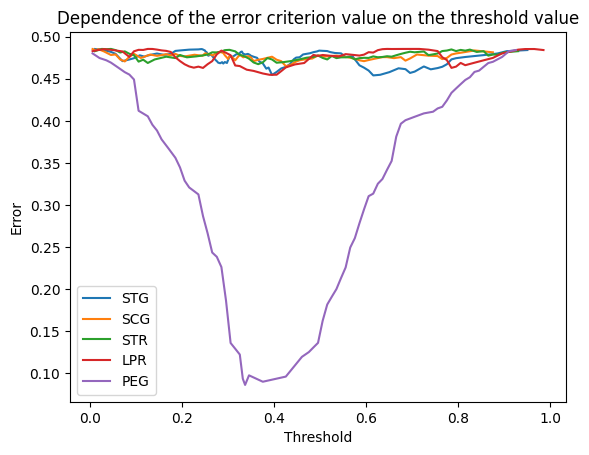

In [ ]:
students = pd.read_csv('students.csv')
students_y = students['UNS']
students_X = students.drop(['Unnamed: 0', 'UNS'], axis=1)

counts = np.bincount(students_y) / len(students_y)
HRm = np.sum(counts * (1 - counts))

for i in students_X.columns:
  best_i = find_best_split(students_X[i], students_y, 'classification')
  plt.plot(best_i[0], -best_i[1] + HRm, label=i)
plt.title('Dependence of the error criterion value on the threshold value')
plt.xlabel('Threshold')
plt.ylabel('Error')
plt.legend()
plt.show()

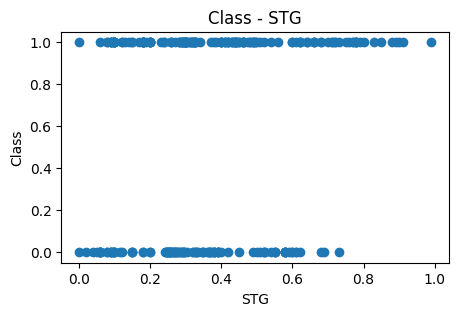

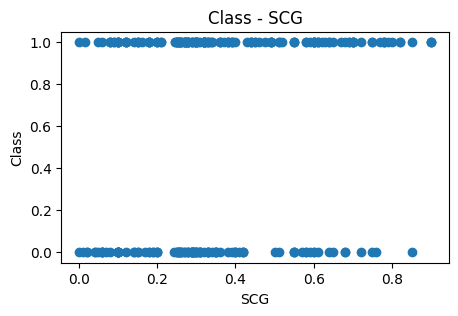

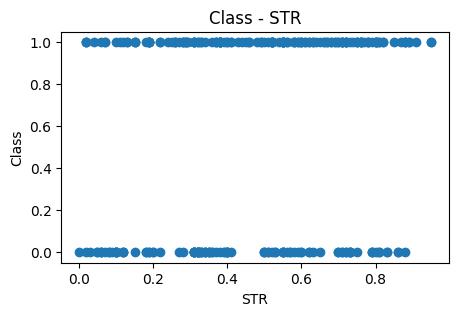

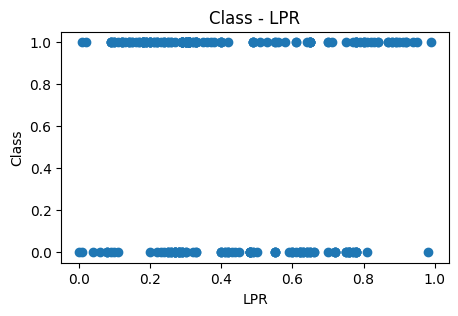

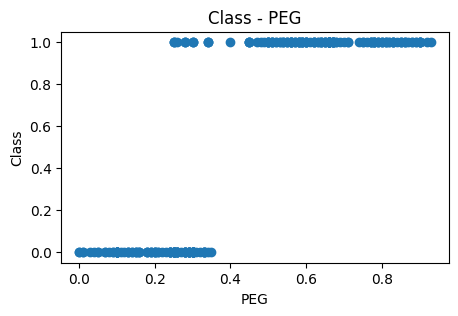

In [ ]:

for i in students_X.columns:
  fig, ax = plt.subplots(figsize=(5, 3))
  ax.scatter(x = students_X[i], y = students_y)
  plt.xlabel(i)
  plt.ylabel("Class")
  plt.title('Class - ' + i)

  plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Исходя из кривых значений критерия Джини, лучше всего производить деление по признаку - PEG.

Этот можно объяснить и с помощью диаграмм рассеяиния. При помощи диаграммы "Class - PEG", можно заметить корреляцию между этим признаком и целевой переменной, PEG < 0.38 относятся скорее к классу 0, а PEG > 0.38 к классу 1. Как раз минимальная ошибка достигается примерно в этом значении, это видно на первом графике пороги-ошибка.
Другие признаки практически не имеют корреляции с целевой переменной, и ошибка не зависит от выбранного порога.

Выборка делится идеально по признаку, если есть такое значение признака при котором, все объекты что меньше этого значения, относятся к одному классу, а те что больше - к другому. Соответсвтвенно кривая для таких признаков будет вылядеть как парабола с ветвями вверх и вершиной в точке этого хорошего значения порога.

Кривые плохих признаков представляют собой практически монотонную линию, по которой видно что всяческое изменение порога не дают достаточных изменений ошибки.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
mushrooms = pd.read_csv('agaricus-lepiota.data')
mushrooms = mushrooms.apply(LabelEncoder().fit_transform)
X_train, X_test, y_train, y_test = train_test_split(mushrooms.drop('p', axis=1), mushrooms['p'], random_state=0, test_size=0.5)

In [ ]:
tree = DecisionTree(["categorical"] * X_train.shape[1])
tree.fit(np.array(X_train), np.array(y_train))
accuracy_score(y_test, tree.predict(np.array(X_test)))

0.999507631708518

In [ ]:
tree.feature_importances

[0.0011906991667706426,
 0.028510878018062,
 0,
 0.12444444444444443,
 0.35471975499688907,
 0,
 0,
 0.42000000000000004,
 0,
 0,
 0.25136946991947,
 0,
 0.01655948489857374,
 0,
 0,
 0,
 0,
 0,
 0,
 0.028303972801077822,
 0,
 0]

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.feature_importances_

array([0.        , 0.        , 0.00282392, 0.0289543 , 0.03697156,
       0.        , 0.        , 0.12272235, 0.34928809, 0.02467132,
       0.01455442, 0.        , 0.0009752 , 0.        , 0.        ,
       0.        , 0.        , 0.01934335, 0.        , 0.19101493,
       0.18013213, 0.02854843])

Конечно не совсем совпадает, но возможно хоть что-то за это получу - идея добавлять критерий информативности, когда признак по всему циклу стал лучшим

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

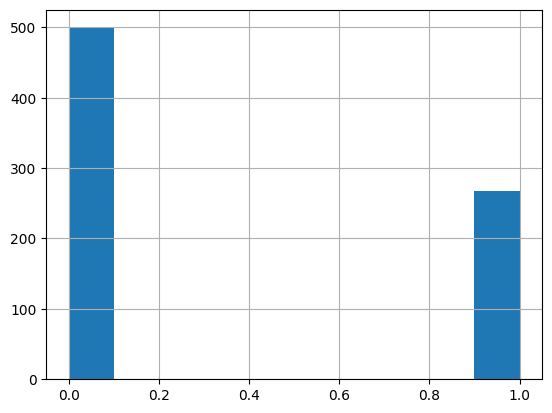

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(data.drop('Outcome', axis=1), data['Outcome'], random_state=0, test_size=0.3)

In [ ]:
X_tt_d, X_tv_d, y_tt_d, y_tv_d = train_test_split(X_train_d, y_train_d, random_state=0, test_size=0.3)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

max_depth рекомендуют начинать с 3 [https://stackoverflow.com/questions/45667010/decide-max-depth-of-decisiontreeclassifier-in-sklearn](https://), возьмем значения от 3 до 30;

по умолчанию, min_samples_leaf = 1, возьмем значения от 1 до 30

In [ ]:
max_depth = [i for i in range(3, 30)]
min_samples_leaf = [i for i in range(1, 30)]

best_depth = max_depth[0]
best_leaf = min_samples_leaf[0]
score = 0

print('max_depth' + '   min_samples_leaf   ' + 'f1_score')
for i in range(len(max_depth)):
  for j in range(len(min_samples_leaf)):
    tree = DecisionTreeClassifier(max_depth=max_depth[i], min_samples_leaf = min_samples_leaf[j])
    tree.fit(X_tt_d, y_tt_d)
    if score < f1_score(y_tv_d, tree.predict(X_tv_d)):
      score = f1_score(y_tv_d, tree.predict(X_tv_d))
      best_depth = max_depth[i]
      best_leaf = min_samples_leaf[j]
print('   '  + str(best_depth) + '           ' + str(best_leaf) + '           ' + str(score))


max_depth   min_samples_leaf   f1_score
   4           28           0.6722689075630253


In [ ]:
main_tree = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 28)
main_tree.fit(X_train_d, y_train_d)
print(f"Accuracy_score: {accuracy_score(y_test_d, main_tree.predict(X_test_d))}")
print(f"Recall_score: {recall_score(y_test_d, main_tree.predict(X_test_d))}")
print(f"Roc_auc_score: {roc_auc_score(y_test_d, main_tree.predict(X_test_d))}")
print(f"F1_score: {f1_score(y_test_d, main_tree.predict(X_test_d))}")


Accuracy_score: 0.7532467532467533
Recall_score: 0.6351351351351351
Roc_auc_score: 0.7220261662936822
F1_score: 0.6225165562913907


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
bagging = BaggingClassifier(n_estimators=50)
bagging.fit(X_train_d, y_train_d)
print(f"Accuracy_score: {accuracy_score(y_test_d, bagging.predict(X_test_d))}")
print(f"Recall_score: {recall_score(y_test_d, bagging.predict(X_test_d))}")
print(f"Roc_auc_score: {roc_auc_score(y_test_d, bagging.predict(X_test_d))}")
print(f"F1_score: {f1_score(y_test_d, bagging.predict(X_test_d))}")

Accuracy_score: 0.7835497835497836
Recall_score: 0.5945945945945946
Roc_auc_score: 0.7336030297813738
F1_score: 0.6376811594202898


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
max_depth = [i for i in range(3, 30)]
min_samples_leaf = [i for i in range(1, 30)]
best_depth = max_depth[0]
best_leaf = min_samples_leaf[0]
score = 0

print('max_depth' + '   min_samples_leaf   ' + 'f1_score')
for i in range(len(max_depth)):
  for j in range(len(min_samples_leaf)):
    forest = RandomForestClassifier(n_estimators = 50, max_depth=max_depth[i], min_samples_leaf = min_samples_leaf[j])
    scores = cross_val_score(forest, X_train_d, y_train_d, cv=5, scoring='f1')
    if np.mean(scores) > score:
      score = np.mean(scores)
      best_depth = max_depth[i]
      best_leaf = min_samples_leaf[j]
print('   '  + str(best_depth) + '           ' + str(best_leaf) + '           ' + str(score))


max_depth   min_samples_leaf   f1_score
   16           14           0.662124060150376


In [ ]:
rf = RandomForestClassifier(n_estimators=50, max_depth=17, min_samples_leaf=4)
rf.fit(X_train_d, y_train_d)
print(f"Accuracy_score: {accuracy_score(y_test_d, rf.predict(X_test_d))}")
print(f"Recall_score: {recall_score(y_test_d, rf.predict(X_test_d))}")
print(f"Roc_auc_score: {roc_auc_score(y_test_d, rf.predict(X_test_d))}")
print(f"F1_score: {f1_score(y_test_d, rf.predict(X_test_d))}")

Accuracy_score: 0.7619047619047619
Recall_score: 0.5135135135135135
Roc_auc_score: 0.6962472026166294
F1_score: 0.5801526717557252


Самые лучшие показатели у BaggingClassifier (самые высокие f1-score и accuracy)





**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [ ]:
n_estimators = [i for i in range(1, 500)]
auc_roc = []

for i in n_estimators:
  forest = RandomForestClassifier(n_estimators = i)
  forest.fit(X_train_d, y_train_d)
  auc_roc.append(roc_auc_score(y_test_d, forest.predict(X_test_d)))


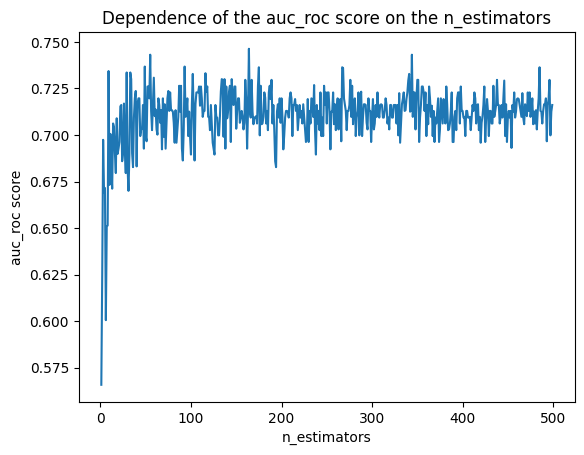

In [ ]:
plt.plot(n_estimators, auc_roc)
plt.title('Dependence of the auc_roc score on the n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('auc_roc score')
plt.show()

Примерно начиная с n_estimators = 75, f1-score от тестовой выборки колеблется в одинаковом диапазоне. Это означает, что случайный лес не переобучается.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

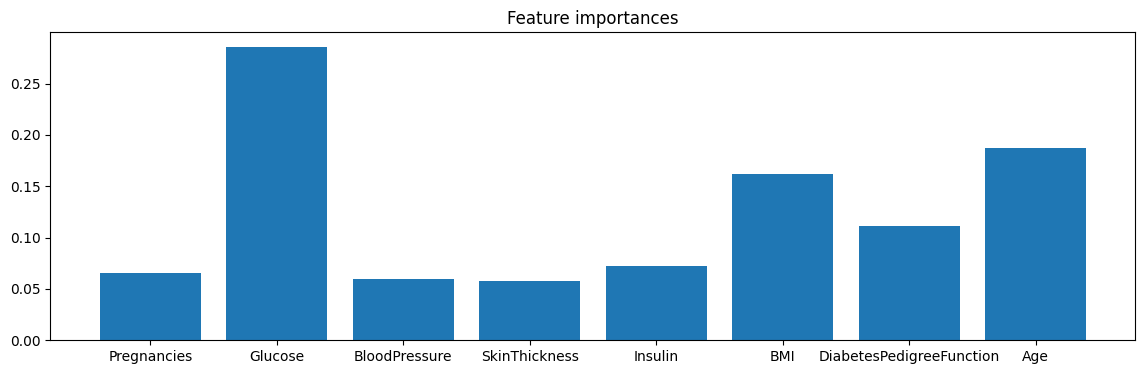

In [ ]:
plt.figure(figsize=(14, 4))
plt.title("Feature importances")
plt.bar(X_train_d.columns, rf.feature_importances_);

Самый лучший признак - концентрация глюкозы в плазме крови